<h1>Stock Market Analysis Project</h1>
<p>This project involves acquiring and analyzing public data of stock market prices. The analysis will focus on evaluating the risk of a stock. The results of this analysis will be used in a Monte Carlo simulation to predict future stock prices.</p>
<h2>Essential Questions</h2>
<p>The questions that will be answered during this project are:
    <ol>
        <li>What was the change in price of the stock over time?</li>
        <li>What was the daily return of the stock on average?</li>
        <li>What was the moving average of the various stocks?</li>
        <li>What was the correlation between different stocks' closing prices</li>
        <li>What was the correlation between different stocks' daily returns?</li>
        <li>How much value do we put at risk by investing in a particular stock?</li>
        <li>How can we attempt to predict future stock behaivor?</li>
    </ol>
</p>

<h2>Basic Analysis of Stock Information</h2>

In [1]:
# imports
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

#statistics
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
sns.set_style('whitegrid') # set white grid background for seaborn
plt.rcParams.update({'font.size': 12})
%matplotlib inline

# data reader
# from pandas.io.data import DataReader  <- Deprecated as of pandas 0.19.0
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

# time stamps
from datetime import datetime
from dateutil import relativedelta

# interation tools
import itertools

In [2]:
tech_list = ['AAPL','GOOG','MSFT','AMZN']

end = datetime.now() - relativedelta.relativedelta(months=6) # end import six months before today (Quandl limits historical data to > 6 months ago)
start = datetime(end.year-1,end.month,end.day) # start import a year previous today

for stock in tech_list:
    # the globals()[stock] makes the name of the data frame the same as the stock name.
    #globals()[stock] = web.DataReader(stock,'quandl',start,end) 
    #globals()[stock].to_csv(stock+'.csv')
    globals()[stock] = pd.read_csv(stock+'.csv',encoding='utf-8')

In [3]:
def add_multiindex(df,df2_list,col_list):
    # df is the original dataframe
    # df2_list is a string list of dataframes to be added to the multiindex
    # col_list is the list of columns in the dataframes to append
    
    # Create a dictionary with keywords from df2_list. The values are the DataFrames found in the globals.
    pieces = dict(zip(df2_list,[globals()[x] for x in df2_list]))
    
    # concatenate the pieces given in the dictionary. 
    # Swap the column level order so that columns in the column list can be selected. 
    tmp=pd.concat(pieces,axis=1,sort=False).swaplevel(i=0,j=1,axis=1)[col_list] 

    
    if df.size==0: 
        return tmp
    else:
        # return pd.concat([df,tmp]).sort_index(axis=0)
        return df.join(tmp, on=None, how='outer', lsuffix='', rsuffix='', sort=True).sort_index(axis=1)


# Create a new dataframe that contains only the adjusted closing values of each stock
closing_df=add_multiindex(DataFrame(),tech_list,['AdjClose'])
    
# Sort the dates so the oldest dates appear first
closing_df.sort_index(axis=0,ascending=True,inplace=True)

# See https://pandas.pydata.org/pandas-docs/stable/cookbook.html#multiindexing
               

<h3>Adjusted Close historical data</h3>

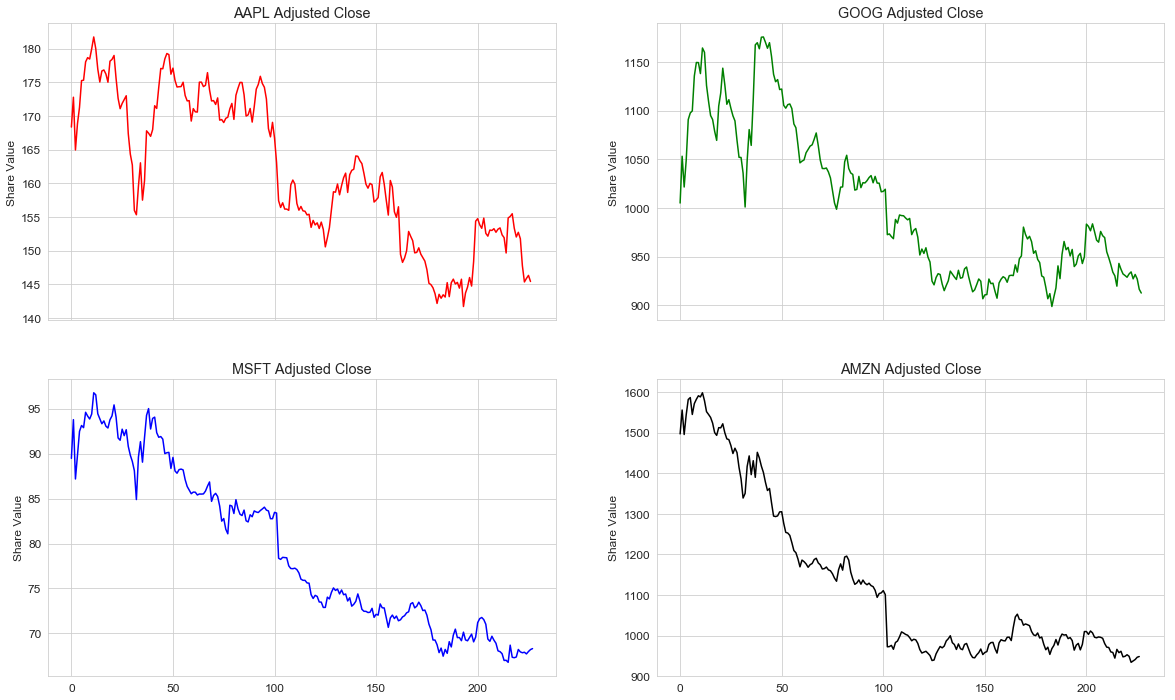

In [4]:
# Graph the historical data
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,12))
colors = ['r','g','b','k']

for i,stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    closing_df[('AdjClose',stock)].dropna().plot(legend=False,ax=ax[i//2,i%2],color=colors[i])
    ax[i//2,i%2].set_title(stock+' Adjusted Close')
    ax[i//2,i%2].set_xlabel('')
    ax[i//2,i%2].set_ylabel('Share Value')

<h3>Moving Averages of Adjusted Close</h3>

In [5]:
ma_day = [10,20,50] # we will create moving averages for 10-day, 20-day, and 50-day intervals
ma_col_list = []

for ma, stock in itertools.product(ma_day,tech_list):
    
    column_name = "%s-day MA" %(str(ma)) # e.g. "10-day MA"
    closing_df[column_name,stock] = globals()[stock]['AdjClose'].sort_index(axis=0,ascending=True).dropna().rolling(ma).mean()


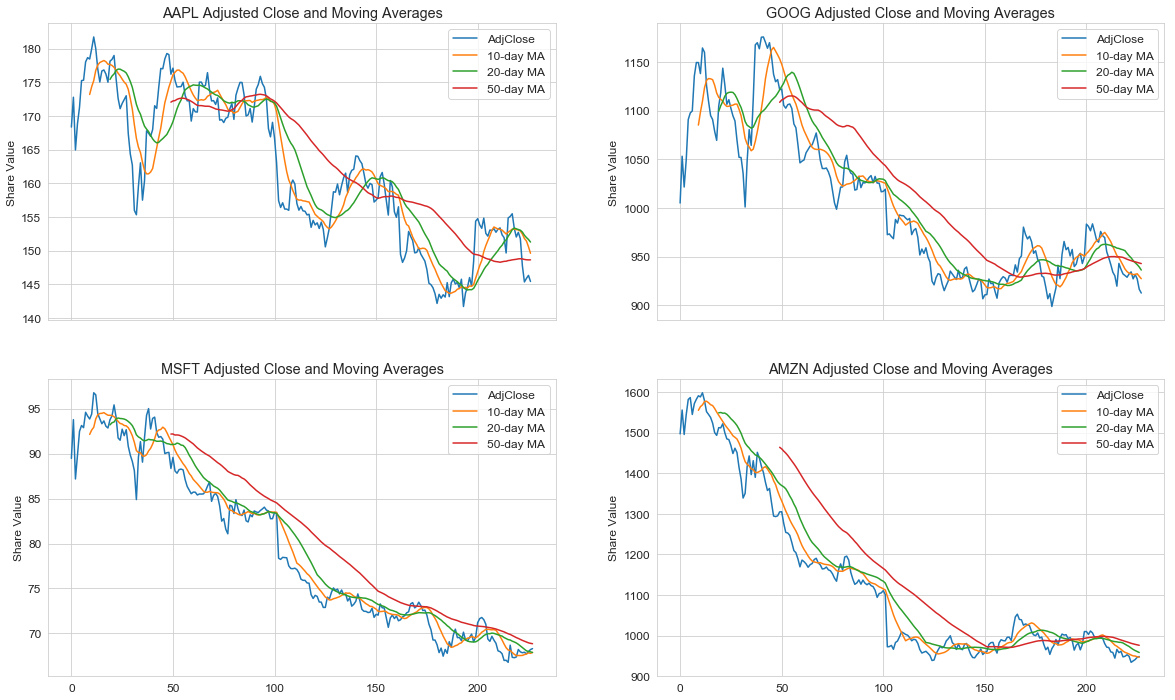

In [6]:
# Graph the moving averages
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,12))
col_list = ['AdjClose','10-day MA','20-day MA','50-day MA']

for i,stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    closing_df.xs(stock,axis=1,level=1).plot(subplots=False,ax=ax[i//2,i%2])
    ax[i//2,i%2].set_title(stock+' Adjusted Close and Moving Averages')
    ax[i//2,i%2].set_xlabel('')
    ax[i//2,i%2].set_ylabel('Share Value')

<h2>Daily Returns</h2>

In [7]:
# Create a new column called "Pct Return" under each stock

for stock in tech_list:
    closing_df[('Pct Return',stock)]=closing_df[('AdjClose',stock)].pct_change()
closing_df.sort_index(axis=1,level=0,sort_remaining=False,inplace=True)

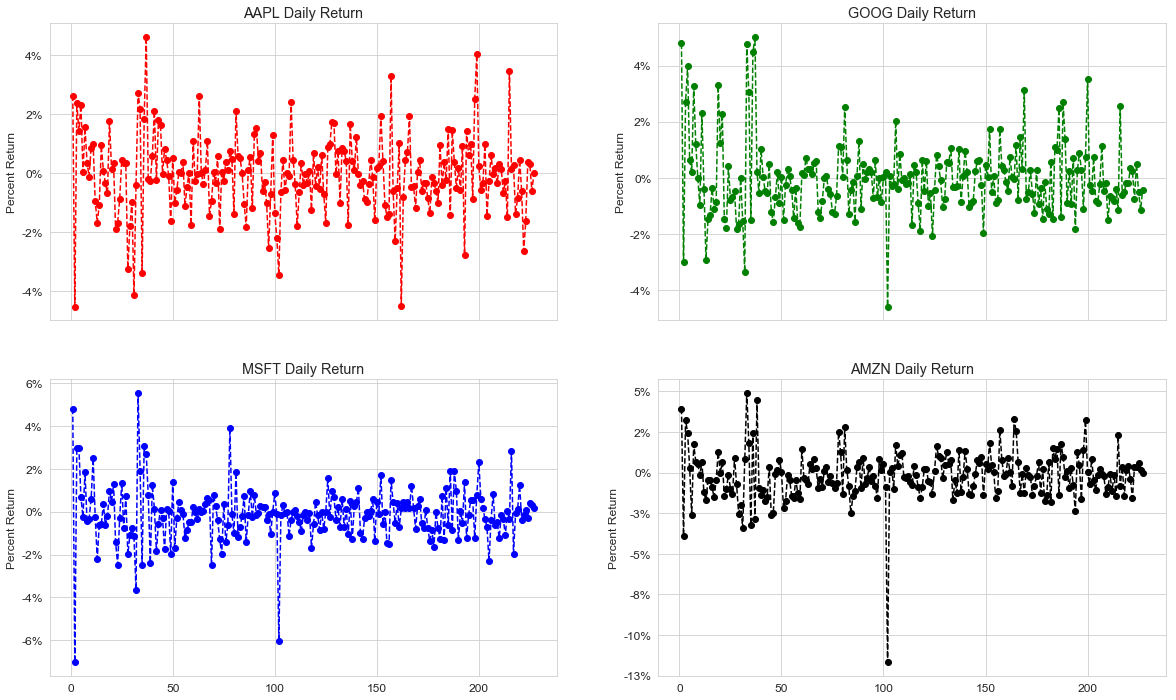

In [8]:
# Graph the daily return for each stock 
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,12))

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).

    closing_df[('Pct Return',stock)].plot(legend=False,linestyle='--',marker='o',ax=ax[i//2,i%2],color=colors[i])
    ax[i//2,i%2].set_title(stock +' Daily Return')
    ax[i//2,i%2].set_xlabel('')
    ax[i//2,i%2].set_ylabel('Percent Return')
                     
    # Format the tick labels as a percentage
    vals = ax[i//2,i%2].get_yticks()
    ax[i//2,i%2].set_yticklabels(['{:,.0%}'.format(x) for x in vals])

<h3> Histograms of daily percent return </h3>

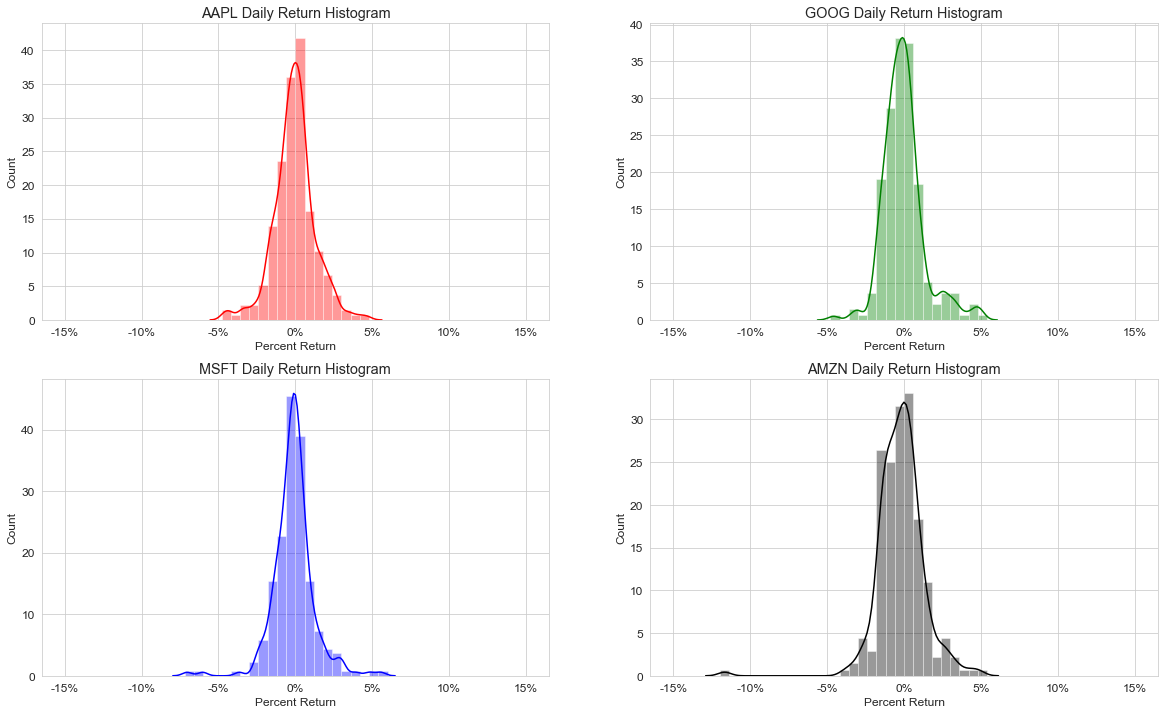

In [9]:
# Graph a histogram of daily return for each stock.
# Note: setting sharex = False and plotting each axis fails to guarantee equal bin sizes.
fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,12))

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).

    # The range of returns is -15% to +15%, set by the hist_kws dictionary.
    sns.distplot(closing_df[('Pct Return',stock)].dropna(),
                 ax=ax[i//2,i%2],color=colors[i], bins=50,
                hist_kws={'range':(-0.15,0.15)})
    ax[i//2,i%2].set_title(stock +' Daily Return Histogram')
    ax[i//2,i%2].set_xlabel('Percent Return')
    ax[i//2,i%2].set_ylabel('Count')
                     
    # Format the tick labels as a percentage
    vals = ax[i//2,i%2].get_xticks()
    ax[i//2,i%2].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    
    
    #Display the x-axis tickmarks for each subplot
    ax[i//2,i%2].tick_params(axis='both', which='both',labelbottom=True)

<h3>Comparing returns between different stocks</h3>

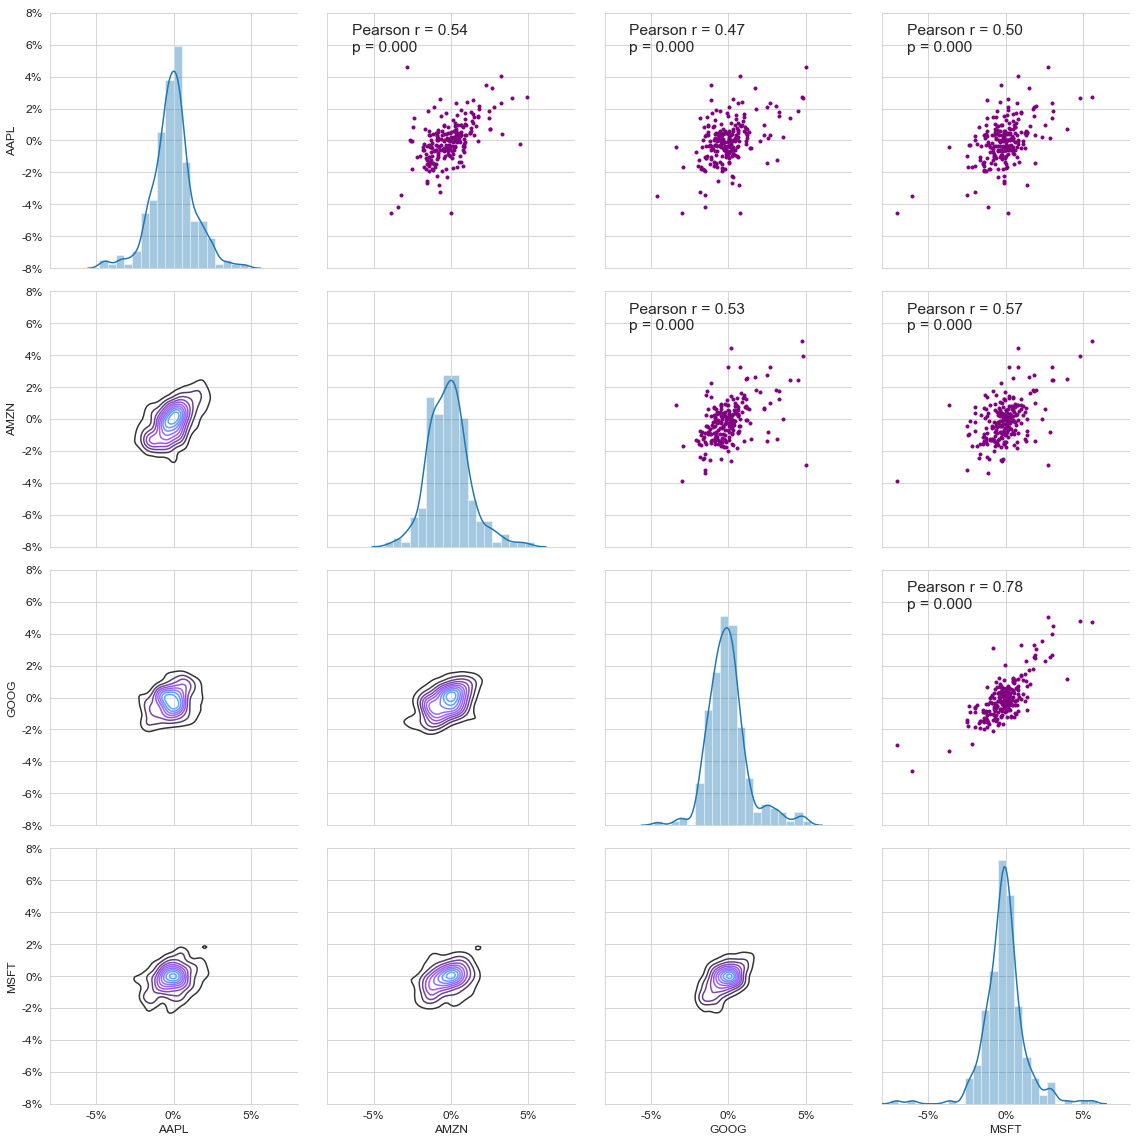

In [10]:
returns_fig = sns.PairGrid(closing_df['Pct Return'].dropna(),height=4,aspect=1)
my_lim = (-0.08,0.08)
sns.set(font_scale=1.3)

def corrfunc(x,y,**kws):
    r, p = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("Pearson r = {:.2f}\np = {:.3f}".format(r,p),
               xy=(0.1,0.85), xycoords=ax.transAxes)

returns_fig.map_upper(plt.scatter,color='purple',marker=".")
returns_fig.map_upper(corrfunc)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(sns.distplot,bins=30,kde_kws={'clip':my_lim},hist_kws={'range':my_lim})

axes = returns_fig.axes
for i,j in itertools.product(np.arange(4),np.arange(4)):

    axes[i,j].set_xlim(my_lim) 
    vals = axes[i,j].get_xticks()
    axes[i,j].set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    
    axes[i,j].set_ylim(my_lim) 
    vals = axes[i,j].get_yticks()
    axes[i,j].set_yticklabels(['{:,.0%}'.format(x) for x in vals])

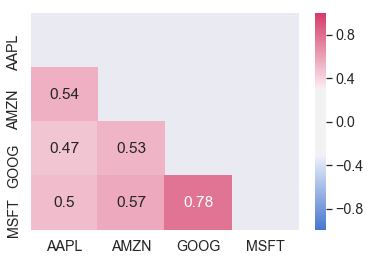

In [11]:
# Create a correlation map
corr = closing_df['Pct Return'].dropna().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1,vmax=+1,cmap=sns.diverging_palette(256,0,sep=80,n=7,as_cmap=True),annot=True,mask=mask)

<h3>Comparing closing prices between stocks</h3>

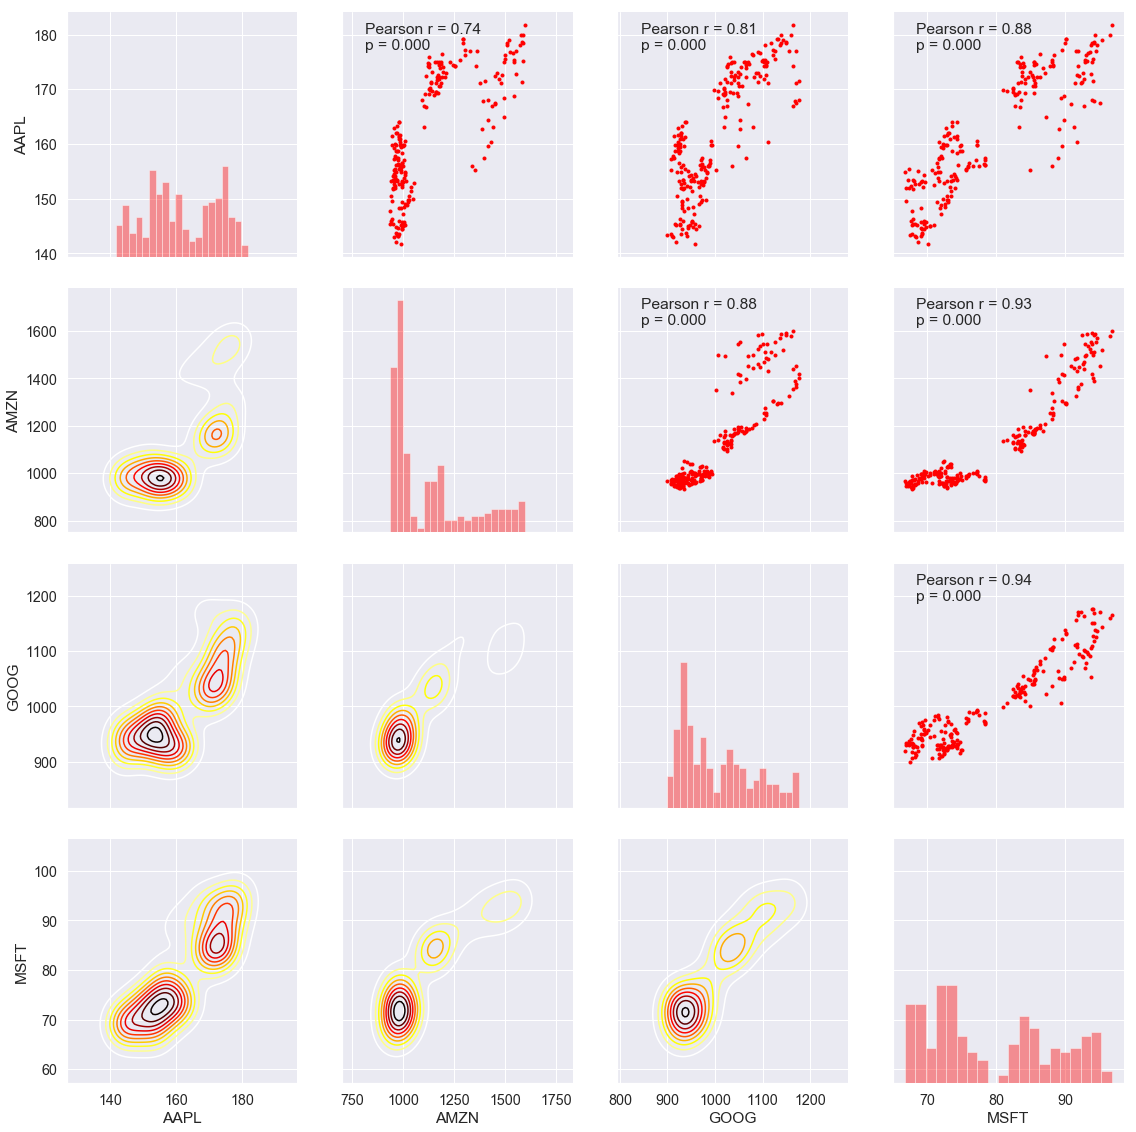

In [12]:
returns_fig = sns.PairGrid(closing_df['AdjClose'].dropna(),height=4,aspect=1)
sns.set(font_scale=1.3)

returns_fig.map_upper(plt.scatter,color='red',marker=".")
returns_fig.map_upper(corrfunc)
returns_fig.map_lower(sns.kdeplot,cmap='hot_r')
returns_fig.map_diag(sns.distplot,bins=20,color='red',kde=False)

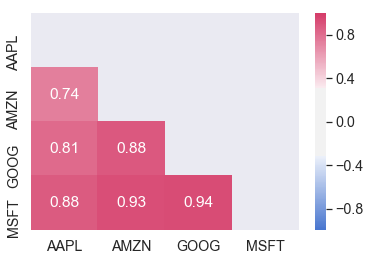

In [13]:
# Create a correlation map
corr = closing_df['AdjClose'].dropna().corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1,vmax=+1,cmap=sns.diverging_palette(256,0,sep=80,n=7,as_cmap=True),annot=True,mask=mask)

<h2>Price and Volume</h2>

<p>Is there a correlation between volume traded and price gain?</p>

<h2>Stock Risk</h2>

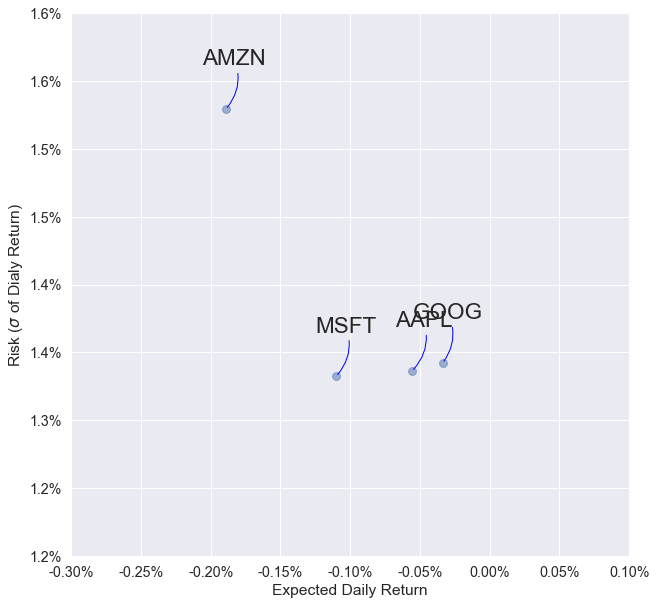

In [14]:
# Define an area for the scatter plot dots
area = np.pi*20

# Create a DataFrame rets as the crossection of pct. daily return
rets = closing_df['Pct Return'].dropna()

# Plot a scatter plot of daily return standard deviation (risk) vs. expected daily return
fig, ax = plt.subplots(figsize = (10,10))

# Define the limits for the scatter plot
ax.set_xlim(-0.003,0.001)
ax.set_ylim(0.012,0.016)

ax.scatter(rets.mean(),rets.std(),alpha=0.5,s=area)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=2))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=1))
ax.set_xlabel('Expected Daily Return')
ax.set_ylabel('Risk ('+ r'$\sigma$' +' of Dialy Return)')

# Annotate each data point
for label, x, y in zip(rets.columns,rets.mean(),rets.std()):
    plt.annotate(
        label,
        xy = (x,y), xytext = (40,40),
        textcoords = 'offset points',ha='right',va='bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3',color='blue')).set_fontsize('x-large')

<h3>Value at risk using the "bootstrap" method</h3>

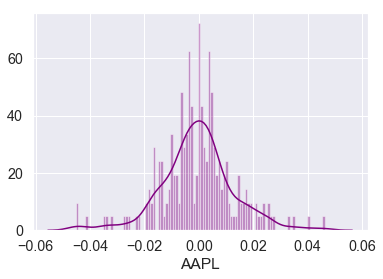

In [15]:
sns.distplot(closing_df['Pct Return']['AAPL'].dropna(),bins=100,color='purple')

In [16]:
# Get the 0.05 empirical quantile of daily returns for each stock
for stock in tech_list:
    q = closing_df['Pct Return'][stock].quantile(0.05)
    print("{0}: {1:.1f}%".format(stock, q*100))

AAPL: -1.9%
GOOG: -1.7%
MSFT: -2.0%
AMZN: -2.1%


<p>With 95% confidence, the maximum amount of loss an investor will experience is the 0.05 empirical quantile shown above. Over this time frame, Google was a slightly less risky stock than the others.</p>

<h2>Periodicity of Stock Data</h2>
<p>To determine if there is any periodicity in the adjusted closing data, I will perform a Fourier transform of the data then graph a power spectrum vs period. If there is any underlying periodic trend, it will show up in the power spectrum as a spike at a particular period.</p>

<h3>Periodicity in adjusted closing price</h3>

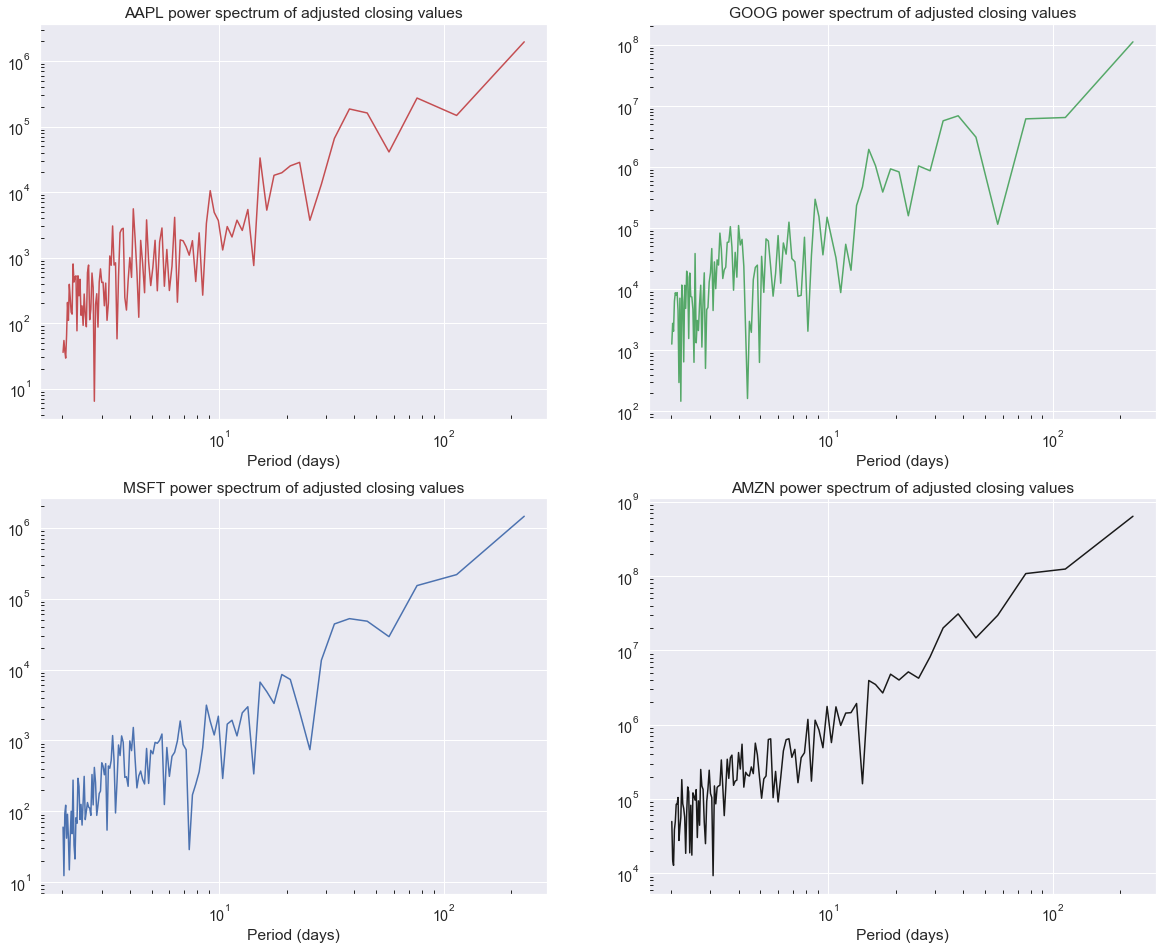

In [84]:
# Compute the array of frequencies for the FFT. The second half of the list of frequencies are negative, so the size of the
# frequency array will be half of the size of the original array.
fft_size = int(closing_df['AdjClose']['AAPL'].size/2)

# Compute the array of periods. We cut off the initial value of the frequency to avoid divsion by zero.  
fft_freq = np.fft.fftfreq(closing_df['AdjClose']['AAPL'].size)
fft_period = 1/(fft_freq[1:fft_size])

# Create a dataframe to store the power spectrum of each transform
power_fft = pd.DataFrame(index=fft_period,columns=tech_list)

fig, ax = plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(20,16))

for i, stock in enumerate(tech_list):
    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).

    # Instead of dropping NA values that will introduce high-frequency noise, we will interpolate to eliminate NaN values
    # The time data are all real values, so using rfft is apporpriate.
    my_fft = np.fft.rfft(closing_df['AdjClose'][stock].interpolate())
    
    # Compute the power at each frequency by multiplying the transform by its own conjugate
    # We will also drop the zero-frequency part of the transform in order to display periods rather than frequency.
    power_fft[stock] = np.real(my_fft*np.conj(my_fft))[1:fft_size]
    
    # Plot the graph 
    ax[i//2,i%2].loglog(fft_period,power_fft[stock],color=colors[i])
    ax[i//2,i%2].set_title(stock +' power spectrum of adjusted closing values')
    ax[i//2,i%2].set_xlabel('Period (days)')
                         
    #Display the x-axis tickmarks for each subplot
    ax[i//2,i%2].tick_params(axis='both', which='both',labelbottom=True)
    
    #Show the minor tick marks for each axis
    ax[i//2,i%2].tick_params(axis='both', which='minor', direction='in', left=True, bottom=True)

<p>All of the stocks appear to have a power spectrum that is a power law of the period. If any periodicity were present, it would appear as a spike or a bump in these data. There is a possible periodicity in Google's stock somewhere on the order of 3-4 days. There is also a slight bump in the power spectrum of Microsoft stock at that same period.</p>

<p>To test how sensitive this spectrum would be to a periodic change in price, I will take one stock's data (Google) and add a periodic sinusoidal wave whose amplitude is 0.1%, 0.5%, and 1% of the stock's mean adjusted closing price. A random value whose standard deviation is 50% of the amplitude will also be added. The period of the added signal will be 10 days.</p>

Text(0,0.5,'Normalized cost')

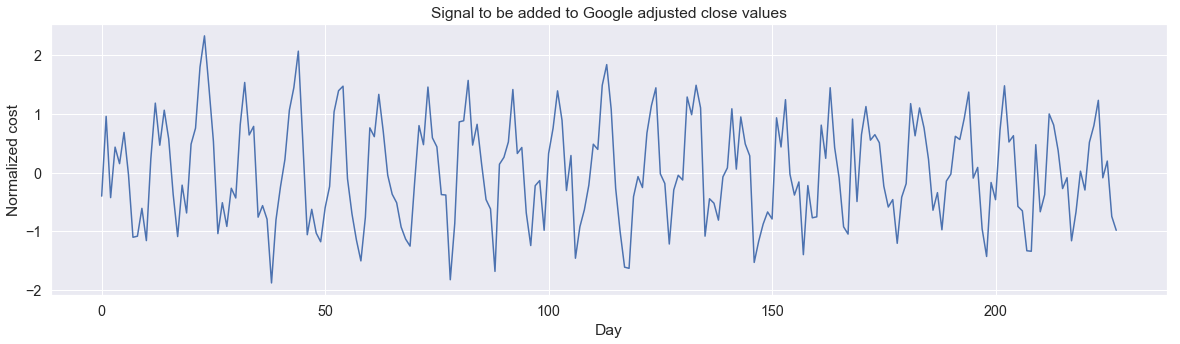

In [138]:
# Determine the amplitude based on the mean of Google's adjusted closing price.
g_mean = closing_df['AdjClose']['GOOG'].dropna().mean()
amp = np.multiply([0,0.005,0.01,0.02],g_mean)
amp_str = ['0%','0.5%','1%','2%']

# Create a sine wave whose period is 10 days (each array element is a day's measurement)
s_size = closing_df['AdjClose']['GOOG'].size
signal = np.arange(s_size)*2*np.pi/10.
signal = np.sin(signal)

# Add some noise to the signal. The noise has a standard deviation of 0.5
signal += 0.5*np.random.randn(s_size)
signal

# Plot the signal that will be added to the time series
fig, ax = plt.subplots(figsize = (20,5))
plt.plot(signal)
ax.set_title('Signal to be added to Google adjusted close values')
ax.set_xlabel('Day')
ax.set_ylabel('Normalized cost')

<p>Even though the signal has a random noise component, its period of ten days can easily be distinguished. Below is what it would look like added onto Google's adjusted closing prices.</p>

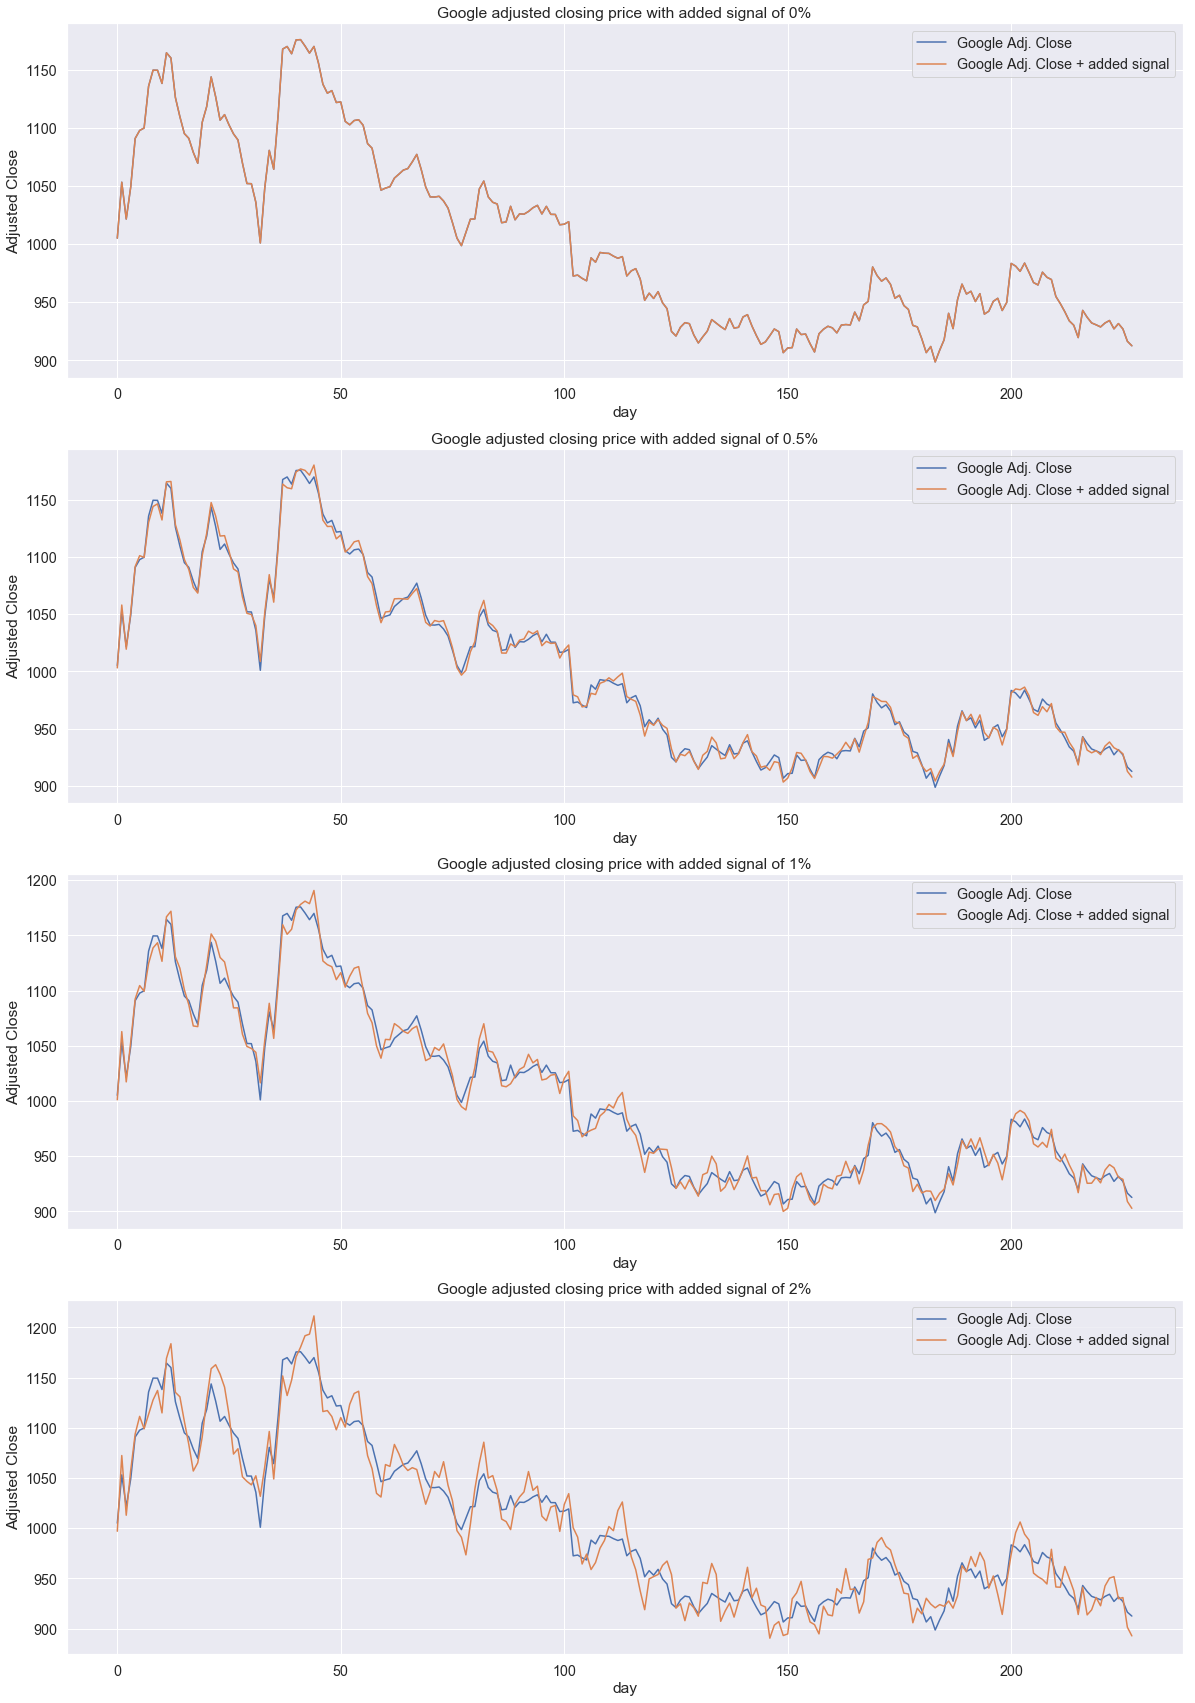

In [141]:
# Create the FFTs and the graphs
fig, ax = plt.subplots(4,1,figsize = (20,30))

# Plot the Google adjusted closing price with and without the additional signal overlayed
for i,a in enumerate(amp):
    # Add the noisy signal to the Google adjusted closing price
    my_data = closing_df['AdjClose']['GOOG'].interpolate()+np.multiply(signal,amp[i])
    ax[i].plot(closing_df['AdjClose']['GOOG'].interpolate())
    ax[i].plot(my_data)
    
    # Create labels for the graph
    ax[i].set_title('Google adjusted closing price with added signal of ' + amp_str[i])
    ax[i].set_xlabel('day')
    ax[i].set_ylabel('Adjusted Close')
    
    # Create labels for the graph
    ax[i].legend(labels=['Google Adj. Close','Google Adj. Close + added signal'])

<p>The added periodic signal can definitely be seen visually when its amplitude is 2% of the mean adjusted closing price. However, it is less discernable when the amplitude is 1% of the mean adjusted closing price or less. Let's see how the power spectrum is affected by the added signal.</p>

(2, 20)

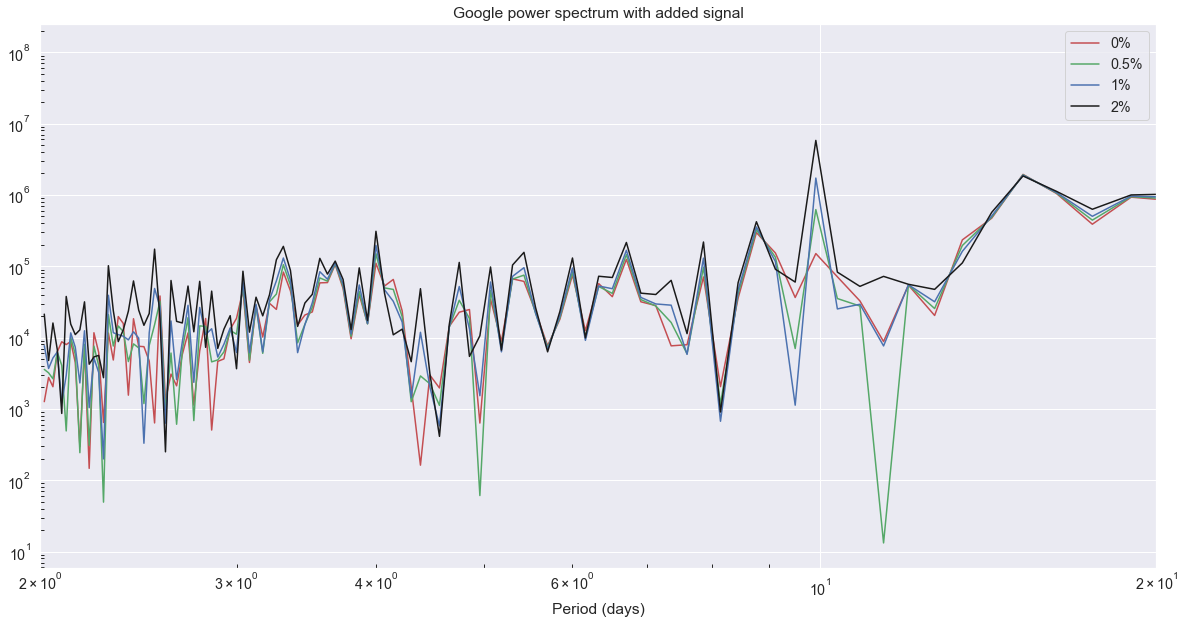

In [142]:
# Create the FFTs and the graphs
fig, ax = plt.subplots(figsize = (20,10))

for i,a in enumerate(amp):
    # Add the noisy signal to the Google adjusted closing price
    my_data = closing_df['AdjClose']['GOOG'].interpolate()+np.multiply(signal,amp[i])

    # Perform the FFT and compute the power spectrum
    my_fft = np.fft.rfft(my_data)
    power = np.real(my_fft*np.conj(my_fft))[1:fft_size]

    # The i=0 plot will go in the top left (0,0). 
    # The i=1 plot will go top right (0,1).
    # The i=2 plot will go bottom left (1,0).
    # The i=3 plot will go bottom right (1,1).
    
    # Plot the graph 
    ax.loglog(fft_period,power,color=colors[i],)

# Create labels for the graph
ax.legend(labels=amp_str)

ax.set_title('Google power spectrum with added signal')
ax.set_xlabel('Period (days)')
    
#Show the minor tick marks for each axis
ax.tick_params(axis='both', which='minor', direction='in', left=True, bottom=True)

#Show only periods up to 20 days for additional detail
ax.set_xlim(left=2,right=20)

<p>A signal that is 1% of the mean closing cost produces a visible spike in the spectrum at 10 days well above the general trend. A signal that is 2% of the mean closing cost would certainly be visible in this spectrum. If Google or the other stocks do have some periodicity, its amplitude is likely not more than 1% of the mean closing cost. This is consistent with the standard deviation of the daily return percentages of 1.3 to 1.6%.</p>